In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

from data_loader import CMAPSSLoader
from preprocessor import CMAPSSPreprocessor

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Load cleaned and featured data
df = pd.read_csv('../data/gold/cmapss/FD001_featured.csv')
print(f"Data shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nColumn names:")
print(df.columns.tolist())
print(f"\nData types:")
print(df.dtypes)

Data shape: (20631, 157)

First few rows:
   engine_id  time_cycles  operational_setting_1  operational_setting_2  \
0          1            1                -0.0007                -0.0004   
1          1            2                 0.0019                -0.0003   
2          1            3                -0.0043                 0.0003   
3          1            4                 0.0007                 0.0000   
4          1            5                -0.0019                -0.0002   

   operational_setting_3  sensor_2  sensor_3  sensor_4  sensor_7  sensor_8  \
0                  100.0  0.183735  0.406802  0.309757  0.726248  0.242424   
1                  100.0  0.283133  0.453019  0.352633  0.628019  0.212121   
2                  100.0  0.343373  0.369523  0.370527  0.710145  0.272727   
3                  100.0  0.343373  0.256159  0.331195  0.740741  0.318182   
4                  100.0  0.349398  0.257467  0.404625  0.668277  0.242424   

   ...  sensor_13_diff  sensor_13_slop

In [3]:
id_cols = ['engine_id', 'time_cycles', 'RUL']
target_col = 'RUL_clipped'
all_cols = df.columns.tolist()
exclude_cols = id_cols + [target_col]
feature_cols = [col for col in all_cols if col not in exclude_cols]


## Train/Validation/Test Split by Engine

Split strategy for time-series data:
- Train set: 70% of engines (for model training)
- Validation set: 15% of engines (for hyperparameter tuning and model selection)
- Test set: 15% of engines (for final evaluation - held out completely)

Important: We split by ENGINE, not by rows, to avoid data leakage

Total engines: 100
Train engines: 70 (70.0%)
Validation engines: 15 (15.0%)
Test engines: 15 (15.0%)

Train samples: 14316
Validation samples: 3170
Test samples: 3145

X_train shape: (14316, 153)
X_val shape: (3170, 153)
X_test shape: (3145, 153)

RUL Distribution:
Train - Mean: 86.49, Std: 41.70, Min: 0.00, Max: 125.00
Val   - Mean: 87.74, Std: 41.59, Min: 0.00, Max: 125.00
Test  - Mean: 87.44, Std: 41.62, Min: 0.00, Max: 125.00


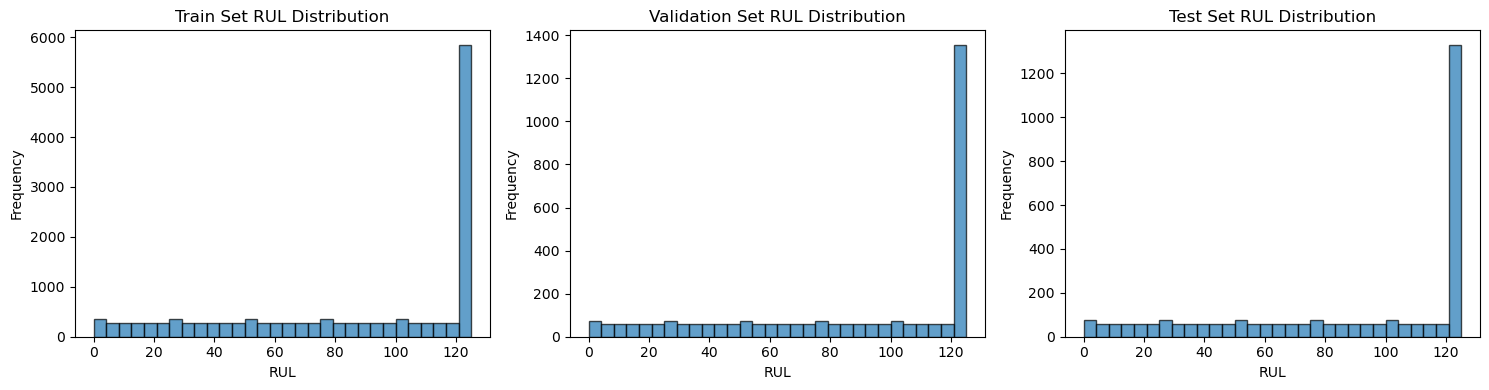

In [4]:
# Get unique engine IDs
engine_ids = df['engine_id'].unique()
n_engines = len(engine_ids)

# Shuffle engines randomly
np.random.seed(42)
np.random.shuffle(engine_ids)

# Calculate split indices
train_split = int(0.70 * n_engines)
val_split = int(0.85 * n_engines)

# Split engine IDs
train_engine_ids = engine_ids[:train_split]
val_engine_ids = engine_ids[train_split:val_split]
test_engine_ids = engine_ids[val_split:]

print(f"Total engines: {n_engines}")
print(f"Train engines: {len(train_engine_ids)} ({len(train_engine_ids)/n_engines*100:.1f}%)")
print(f"Validation engines: {len(val_engine_ids)} ({len(val_engine_ids)/n_engines*100:.1f}%)")
print(f"Test engines: {len(test_engine_ids)} ({len(test_engine_ids)/n_engines*100:.1f}%)")

# Create train, validation, and test sets
train_set = df[df['engine_id'].isin(train_engine_ids)].copy()
val_set = df[df['engine_id'].isin(val_engine_ids)].copy()
test_set = df[df['engine_id'].isin(test_engine_ids)].copy()

print(f"\nTrain samples: {len(train_set)}")
print(f"Validation samples: {len(val_set)}")
print(f"Test samples: {len(test_set)}")

# Prepare X and y for each set
X_train = train_set[feature_cols]
y_train = train_set[target_col]

X_val = val_set[feature_cols]
y_val = val_set[target_col]

X_test = test_set[feature_cols]
y_test = test_set[target_col]

print(f"\nX_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

# Check RUL distribution across splits
print("\nRUL Distribution:")
print(f"Train - Mean: {y_train.mean():.2f}, Std: {y_train.std():.2f}, Min: {y_train.min():.2f}, Max: {y_train.max():.2f}")
print(f"Val   - Mean: {y_val.mean():.2f}, Std: {y_val.std():.2f}, Min: {y_val.min():.2f}, Max: {y_val.max():.2f}")
print(f"Test  - Mean: {y_test.mean():.2f}, Std: {y_test.std():.2f}, Min: {y_test.min():.2f}, Max: {y_test.max():.2f}")

# Visualize the split
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(y_train, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title('Train Set RUL Distribution')
axes[0].set_xlabel('RUL')
axes[0].set_ylabel('Frequency')

axes[1].hist(y_val, bins=30, edgecolor='black', alpha=0.7)
axes[1].set_title('Validation Set RUL Distribution')
axes[1].set_xlabel('RUL')
axes[1].set_ylabel('Frequency')

axes[2].hist(y_test, bins=30, edgecolor='black', alpha=0.7)
axes[2].set_title('Test Set RUL Distribution')
axes[2].set_xlabel('RUL')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## Feature Correlation Analysis

Identify what features correlate with RUL

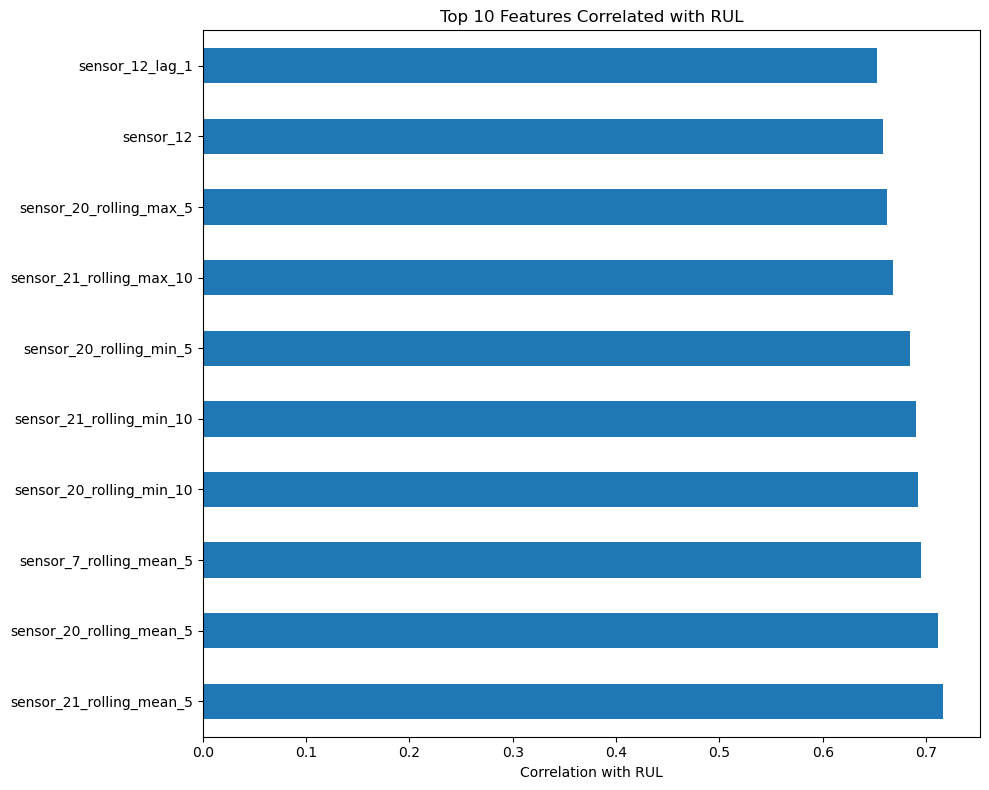

Top 10 positive correlations:
sensor_21_rolling_mean_5    0.716270
sensor_20_rolling_mean_5    0.711823
sensor_7_rolling_mean_5     0.695366
sensor_20_rolling_min_10    0.692041
sensor_21_rolling_min_10    0.689989
sensor_20_rolling_min_5     0.684095
sensor_21_rolling_max_10    0.667437
sensor_20_rolling_max_5     0.662302
sensor_12                   0.657846
sensor_12_lag_1             0.652533
Name: RUL, dtype: float64

Top 10 negative correlations:
sensor_3_rolling_max_10    -0.681846
sensor_17_rolling_max_20   -0.683026
sensor_11                  -0.683801
sensor_3_rolling_max_20    -0.687386
sensor_3_rolling_mean_5    -0.699966
sensor_2_rolling_mean_5    -0.700332
sensor_17_rolling_mean_5   -0.709937
sensor_15_rolling_mean_5   -0.712472
sensor_4_rolling_mean_5    -0.723301
operational_setting_3            NaN
Name: RUL, dtype: float64


In [5]:
# Calculate correlation with RUL
correlations = train_set[feature_cols + ['RUL']].corr()['RUL'].drop('RUL').sort_values(ascending=False)

# Plot top correlations
fig, ax = plt.subplots(figsize=(10, 8))
top_n = 10
correlations.head(top_n).plot(kind='barh', ax=ax)
ax.set_xlabel('Correlation with RUL')
ax.set_title(f'Top {top_n} Features Correlated with RUL')
plt.tight_layout()
plt.show()

print("Top 10 positive correlations:")
print(correlations.head(10))
print("\nTop 10 negative correlations:")
print(correlations.tail(10))

## Evaluation Functions

In [6]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    """
    Evaluate model performance with multiple metrics
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    # Penalizes late predictions more than early predictions
    errors = y_pred - y_true
    score = 0
    for error in errors:
        if error < 0:  # Early prediction
            score += np.exp(-error/13) - 1
        else:  # Late prediction
            score += np.exp(error/10) - 1
    
    print(f"{model_name} Performance:")
    print(f"MAE:   {mae:.4f}")
    print(f"RMSE:  {rmse:.4f}")
    print(f"R²:    {r2:.4f}")
    print(f"Score: {score:.4f} (lower is better)")
    
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'Score': score}

def plot_predictions(y_true, y_pred, model_name="Model"):
    """
    Plot predicted vs actual RUL
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Scatter plot
    axes[0].scatter(y_true, y_pred, alpha=0.5)
    axes[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    axes[0].set_xlabel('Actual RUL')
    axes[0].set_ylabel('Predicted RUL')
    axes[0].set_title(f'{model_name}: Predicted vs Actual RUL')
    axes[0].grid(True, alpha=0.3)
    
    # Error distribution
    errors = y_pred - y_true
    axes[1].hist(errors, bins=50, edgecolor='black', alpha=0.7)
    axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)
    axes[1].set_xlabel('Prediction Error (Predicted - Actual)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title(f'{model_name}: Error Distribution')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Baseline 1 - Linear Regression

Training Linear Regression...

--- TRAINING SET ---
Linear Regression (Train) Performance:
MAE:   15.8960
RMSE:  19.5801
R²:    0.7795
Score: 104723.9002 (lower is better)

--- VALIDATION SET ---
Linear Regression (Val) Performance:
MAE:   15.6681
RMSE:  19.2901
R²:    0.7848
Score: 25472.0607 (lower is better)


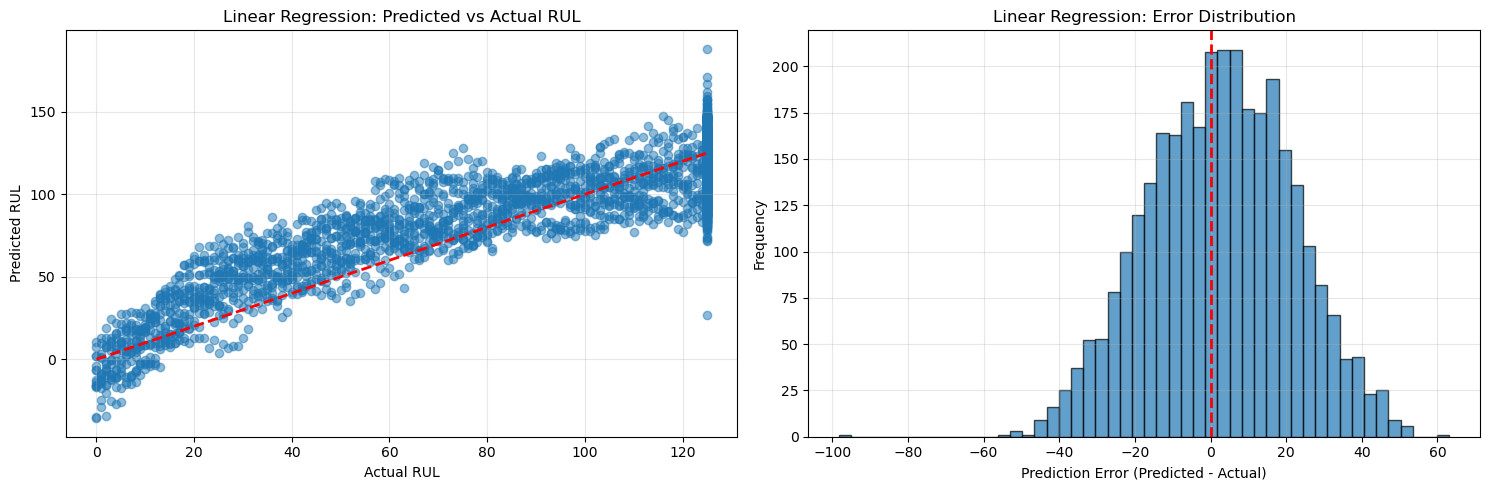

In [7]:
print("Training Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
y_train_pred_lr = lr_model.predict(X_train)
y_val_pred_lr = lr_model.predict(X_val)

# Evaluate
print("\n--- TRAINING SET ---")
train_results_lr = evaluate_model(y_train, y_train_pred_lr, "Linear Regression (Train)")

print("\n--- VALIDATION SET ---")
val_results_lr = evaluate_model(y_val, y_val_pred_lr, "Linear Regression (Val)")

# Plot
plot_predictions(y_val, y_val_pred_lr, "Linear Regression")

## Baselin 2 - Ridge Regression

Training Ridge Regression...
Alpha=0.1: RMSE=19.2845
Alpha=1.0: RMSE=19.2650
Alpha=10.0: RMSE=19.4020
Alpha=100.0: RMSE=20.1329

Best alpha: 1.0

--- TRAINING SET ---
Ridge Regression (Train) Performance:
MAE:   15.9159
RMSE:  19.5906
R²:    0.7793
Score: 104066.6549 (lower is better)

--- VALIDATION SET ---
Ridge Regression (Val) Performance:
MAE:   15.6801
RMSE:  19.2650
R²:    0.7854
Score: 24121.3844 (lower is better)


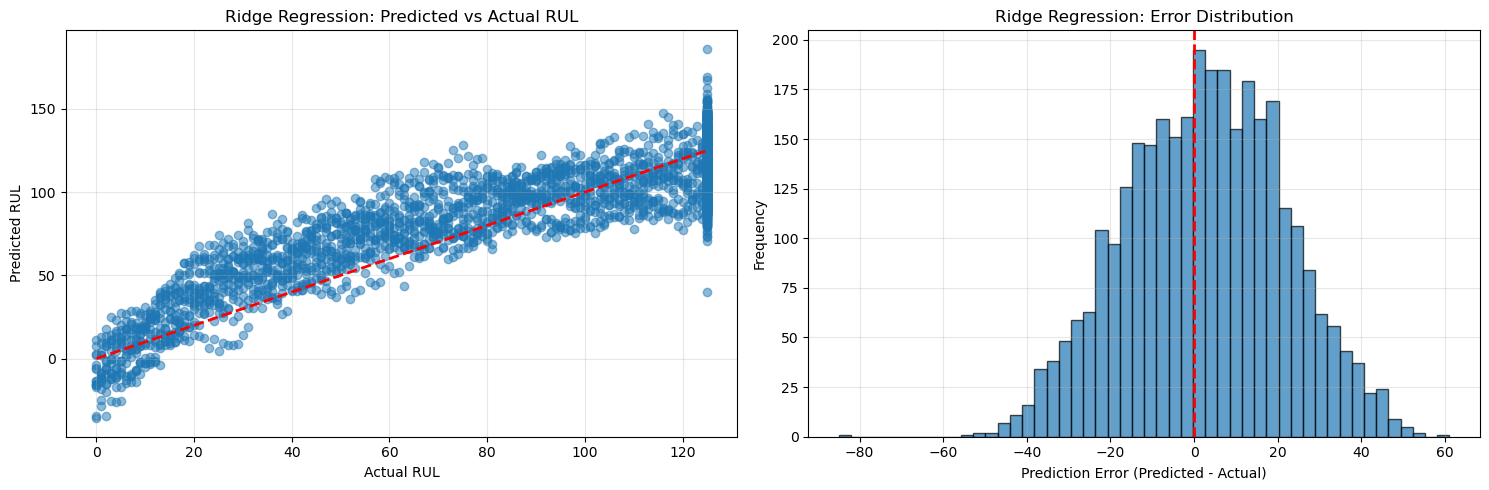

In [8]:
print("Training Ridge Regression...")

# Try different alpha values
alphas = [0.1, 1.0, 10.0, 100.0]
best_alpha = None
best_score = float('inf')

for alpha in alphas:
    ridge = Ridge(alpha=alpha, random_state=42)
    ridge.fit(X_train, y_train)
    y_val_pred = ridge.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    print(f"Alpha={alpha}: RMSE={rmse:.4f}")
    
    if rmse < best_score:
        best_score = rmse
        best_alpha = alpha

print(f"\nBest alpha: {best_alpha}")

# Train final model with best alpha
ridge_model = Ridge(alpha=best_alpha, random_state=42)
ridge_model.fit(X_train, y_train)

# Predictions
y_train_pred_ridge = ridge_model.predict(X_train)
y_val_pred_ridge = ridge_model.predict(X_val)

# Evaluate
print("\n--- TRAINING SET ---")
train_results_ridge = evaluate_model(y_train, y_train_pred_ridge, "Ridge Regression (Train)")

print("\n--- VALIDATION SET ---")
val_results_ridge = evaluate_model(y_val, y_val_pred_ridge, "Ridge Regression (Val)")

# Plot
plot_predictions(y_val, y_val_pred_ridge, "Ridge Regression")

## Baseline 3 - Lasso Regression

Training Lasso Regression...
Alpha=0.1: RMSE=20.4868
Alpha=1.0: RMSE=22.4126
Alpha=10.0: RMSE=41.6015
Alpha=100.0: RMSE=41.6015

Best alpha: 0.1

--- TRAINING SET ---
Lasso Regression (Train) Performance:
MAE:   17.1802
RMSE:  21.0324
R²:    0.7456
Score: 122250.3705 (lower is better)

--- VALIDATION SET ---
Lasso Regression (Val) Performance:
MAE:   16.9948
RMSE:  20.4868
R²:    0.7573
Score: 26968.3628 (lower is better)


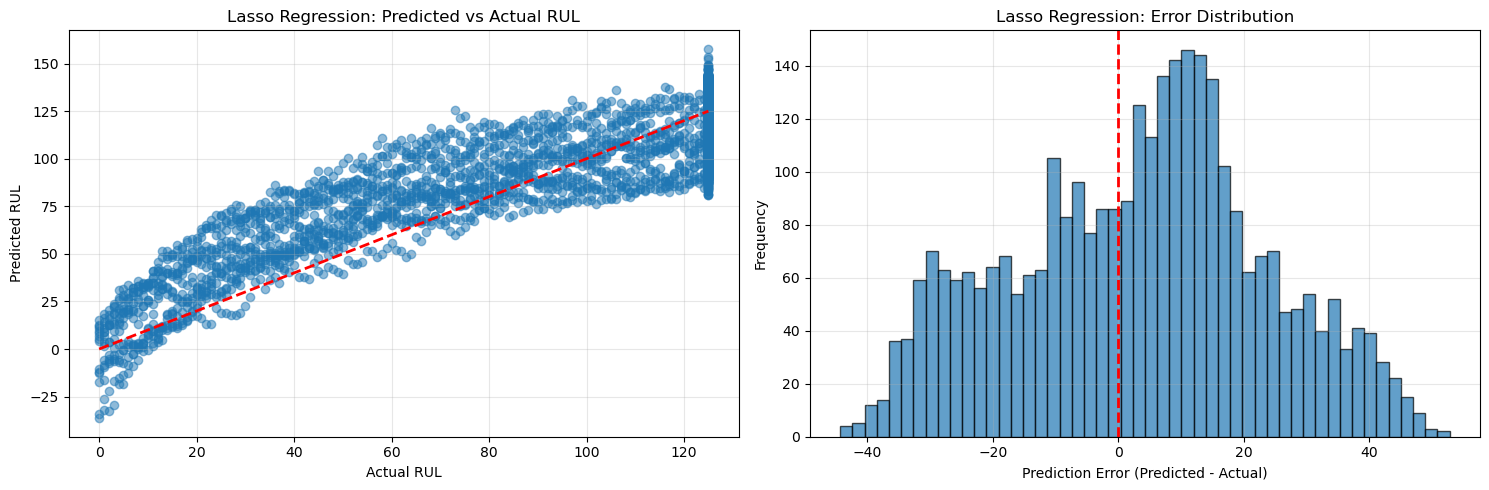


Lasso selected 33 out of 153 features


In [9]:
print("Training Lasso Regression...")

# Try different alpha values
alphas = [0.1, 1.0, 10.0, 100.0]
best_alpha = None
best_score = float('inf')

for alpha in alphas:
    lasso = Lasso(alpha=alpha, random_state=42, max_iter=10000)
    lasso.fit(X_train, y_train)
    y_val_pred = lasso.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    print(f"Alpha={alpha}: RMSE={rmse:.4f}")
    
    if rmse < best_score:
        best_score = rmse
        best_alpha = alpha

print(f"\nBest alpha: {best_alpha}")

# Train final model with best alpha
lasso_model = Lasso(alpha=best_alpha, random_state=42, max_iter=10000)
lasso_model.fit(X_train, y_train)

# Predictions
y_train_pred_lasso = lasso_model.predict(X_train)
y_val_pred_lasso = lasso_model.predict(X_val)

# Evaluate
print("\n--- TRAINING SET ---")
train_results_lasso = evaluate_model(y_train, y_train_pred_lasso, "Lasso Regression (Train)")

print("\n--- VALIDATION SET ---")
val_results_lasso = evaluate_model(y_val, y_val_pred_lasso, "Lasso Regression (Val)")

# Plot
plot_predictions(y_val, y_val_pred_lasso, "Lasso Regression")

# Check which features were selected (non-zero coefficients)
selected_features = np.sum(lasso_model.coef_ != 0)
print(f"\nLasso selected {selected_features} out of {len(feature_cols)} features")

## Baseline 4 - Random Forest

Training Random Forest...

--- TRAINING SET ---
Random Forest (Train) Performance:
MAE:   4.9447
RMSE:  7.2312
R²:    0.9699
Score: 13073.0937 (lower is better)

--- VALIDATION SET ---
Random Forest (Val) Performance:
MAE:   13.6726
RMSE:  19.1871
R²:    0.7871
Score: 56133.9168 (lower is better)


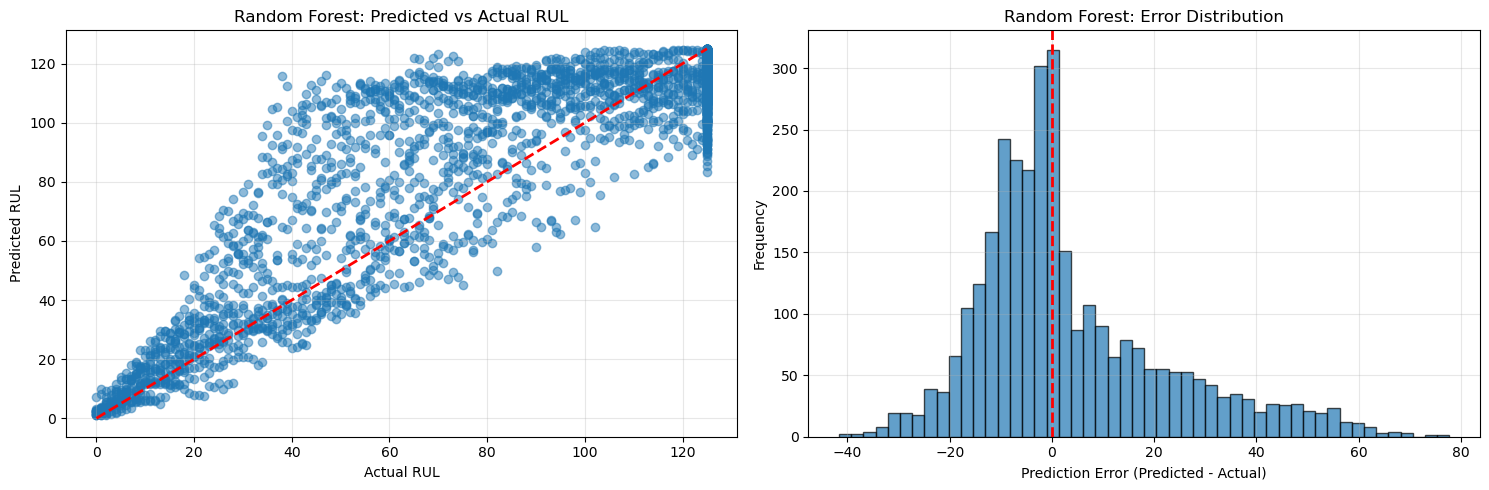

In [10]:
print("Training Random Forest...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# Predictions
y_train_pred_rf = rf_model.predict(X_train)
y_val_pred_rf = rf_model.predict(X_val)

# Evaluate
print("\n--- TRAINING SET ---")
train_results_rf = evaluate_model(y_train, y_train_pred_rf, "Random Forest (Train)")

print("\n--- VALIDATION SET ---")
val_results_rf = evaluate_model(y_val, y_val_pred_rf, "Random Forest (Val)")

# Plot
plot_predictions(y_val, y_val_pred_rf, "Random Forest")

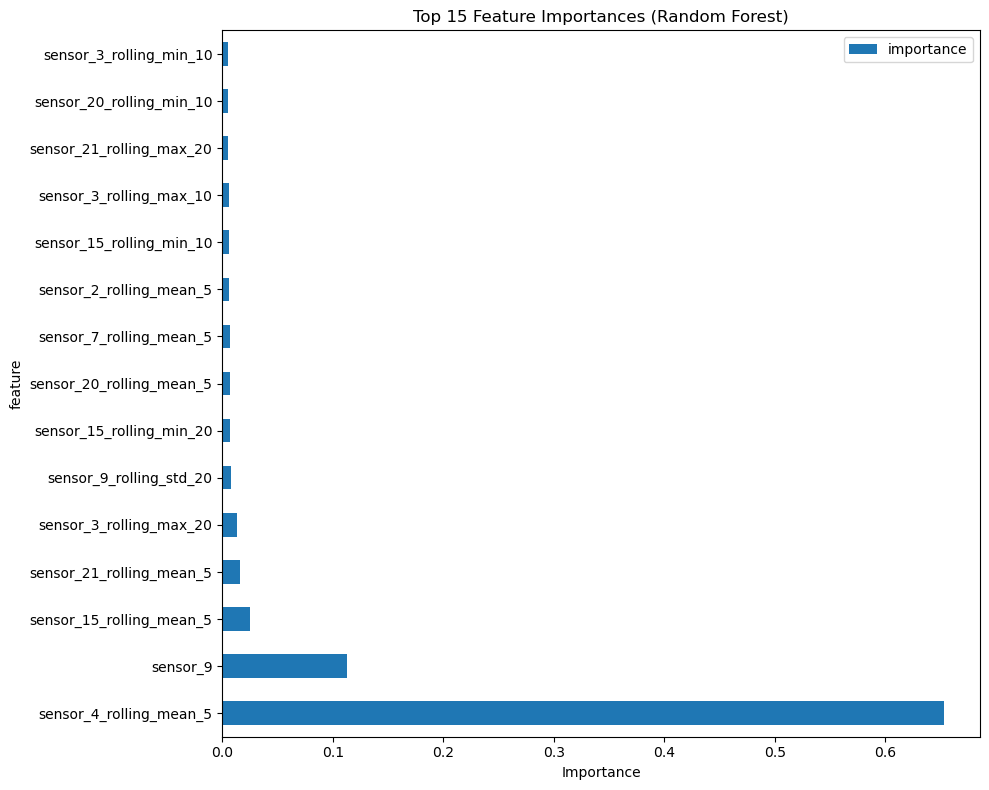

Top 15 Most Important Features:
                     feature  importance
24   sensor_4_rolling_mean_5    0.652878
8                   sensor_9    0.113055
34  sensor_15_rolling_mean_5    0.024711
44  sensor_21_rolling_mean_5    0.015921
74   sensor_3_rolling_max_20    0.013472
78   sensor_9_rolling_std_20    0.007551
83  sensor_15_rolling_min_20    0.007436
40  sensor_20_rolling_mean_5    0.007261
26   sensor_7_rolling_mean_5    0.007008
16   sensor_2_rolling_mean_5    0.006434
60  sensor_15_rolling_min_10    0.006021
51   sensor_3_rolling_max_10    0.005791
90  sensor_21_rolling_max_20    0.005294
65  sensor_20_rolling_min_10    0.005255
50   sensor_3_rolling_min_10    0.005199


In [11]:
# Get feature importances
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 15 features
fig, ax = plt.subplots(figsize=(10, 8))
feature_importance.head(15).plot(x='feature', y='importance', kind='barh', ax=ax)
ax.set_xlabel('Importance')
ax.set_title('Top 15 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()

print("Top 15 Most Important Features:")
print(feature_importance.head(15))

## Baseline 5 - Gradient Boosting

Training Gradient Boosting...

--- TRAINING SET ---
Gradient Boosting (Train) Performance:
MAE:   6.7645
RMSE:  9.3004
R²:    0.9503
Score: 20203.3753 (lower is better)

--- VALIDATION SET ---
Gradient Boosting (Val) Performance:
MAE:   13.3351
RMSE:  18.8188
R²:    0.7952
Score: 50371.1476 (lower is better)


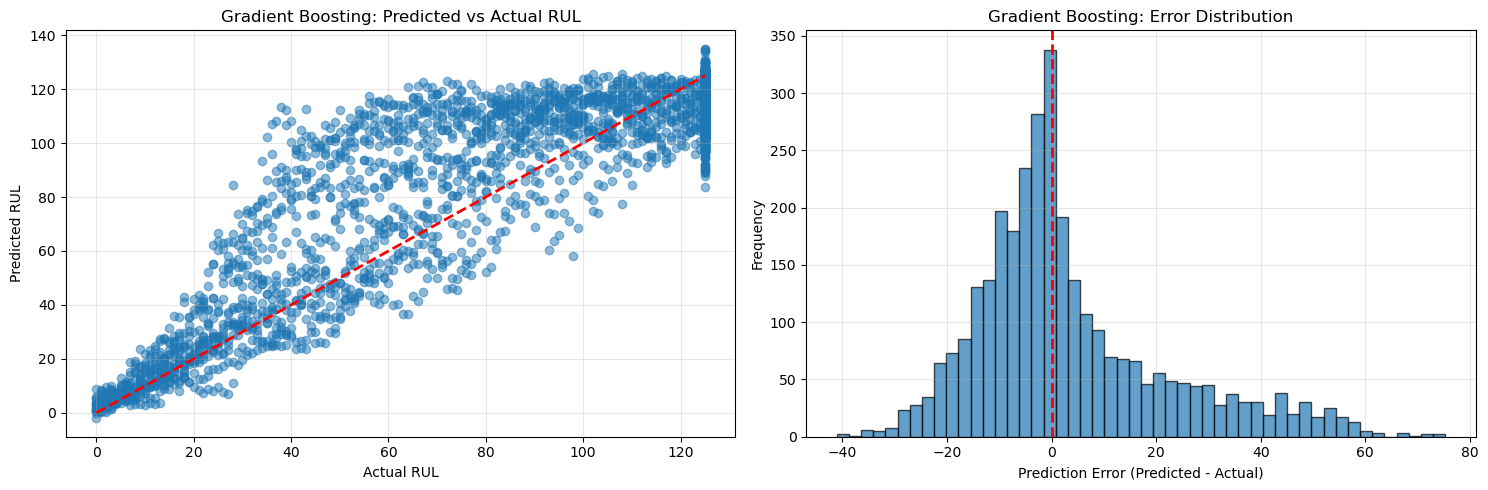

In [12]:
print("Training Gradient Boosting...")
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42
)
gb_model.fit(X_train, y_train)

# Predictions
y_train_pred_gb = gb_model.predict(X_train)
y_val_pred_gb = gb_model.predict(X_val)

# Evaluate
print("\n--- TRAINING SET ---")
train_results_gb = evaluate_model(y_train, y_train_pred_gb, "Gradient Boosting (Train)")

print("\n--- VALIDATION SET ---")
val_results_gb = evaluate_model(y_val, y_val_pred_gb, "Gradient Boosting (Val)")

# Plot
plot_predictions(y_val, y_val_pred_gb, "Gradient Boosting")

## Comparison

VALIDATION SET COMPARISON
            Model       MAE      RMSE       R²        Score
Linear Regression 15.668110 19.290116 0.784802 25472.060684
            Ridge 15.680064 19.264963 0.785363 24121.384379
            Lasso 16.994832 20.486785 0.757274 26968.362808
    Random Forest 13.672584 19.187136 0.787093 56133.916777
Gradient Boosting 13.335072 18.818756 0.795190 50371.147571


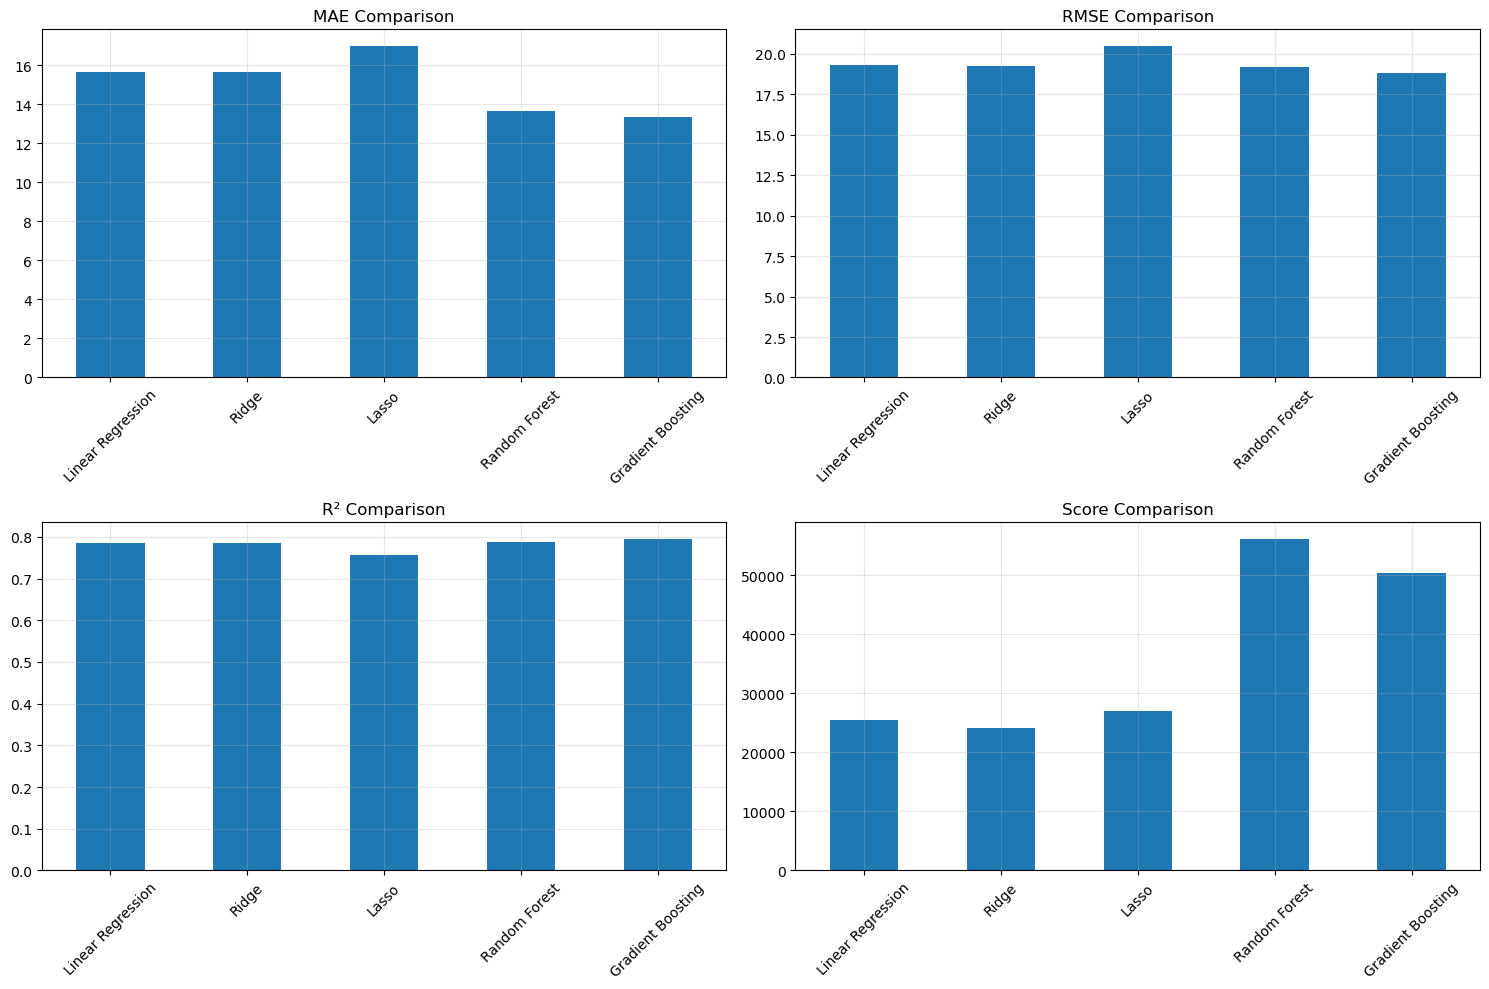


 Best Model (by RMSE): Gradient Boosting


In [13]:
# Compile results
results_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge', 'Lasso', 'Random Forest', 'Gradient Boosting'],
    'MAE': [val_results_lr['MAE'], val_results_ridge['MAE'], val_results_lasso['MAE'], 
            val_results_rf['MAE'], val_results_gb['MAE']],
    'RMSE': [val_results_lr['RMSE'], val_results_ridge['RMSE'], val_results_lasso['RMSE'], 
             val_results_rf['RMSE'], val_results_gb['RMSE']],
    'R²': [val_results_lr['R2'], val_results_ridge['R2'], val_results_lasso['R2'], 
           val_results_rf['R2'], val_results_gb['R2']],
    'Score': [val_results_lr['Score'], val_results_ridge['Score'], val_results_lasso['Score'], 
              val_results_rf['Score'], val_results_gb['Score']]
})

print("VALIDATION SET COMPARISON")
print(results_comparison.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics = ['MAE', 'RMSE', 'R²', 'Score']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    results_comparison.plot(x='Model', y=metric, kind='bar', ax=ax, legend=False)
    ax.set_title(f'{metric} Comparison')
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Identify best model
best_model_idx = results_comparison['RMSE'].idxmin()
best_model = results_comparison.loc[best_model_idx, 'Model']
print(f"\n Best Model (by RMSE): {best_model}")


Error Analysis by RUL Range:
                mean        std  count
RUL_Range                             
0-50       14.872524  16.963133    750
50-100     23.246960  14.600939    750
100-150     8.892419   7.361382   1655


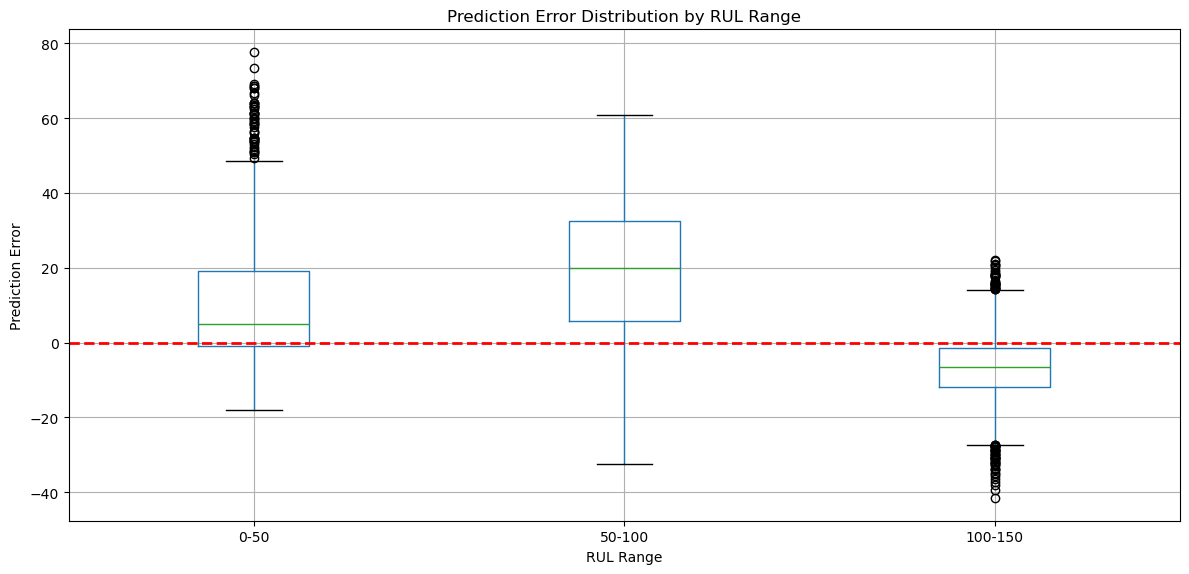

In [18]:
# Analyze errors across different RUL ranges
# Use the best model (e.g., Random Forest)
y_pred_best = y_val_pred_rf

# Create RUL bins
rul_bins = [0, 50, 100, 150]
rul_labels = ['0-50', '50-100', '100-150']
rul_binned = pd.cut(y_val, bins=rul_bins, labels=rul_labels)

# Calculate errors by bin
error_by_rul = pd.DataFrame({
    'RUL_Range': rul_binned,
    'Actual': y_val,
    'Predicted': y_pred_best,
    'Error': y_pred_best - y_val,
    'Abs_Error': np.abs(y_pred_best - y_val)
})

# Summary statistics
print("\nError Analysis by RUL Range:")
print(error_by_rul.groupby('RUL_Range')['Abs_Error'].agg(['mean', 'std', 'count']))

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
error_by_rul.boxplot(column='Error', by='RUL_Range', ax=ax)
ax.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax.set_title('Prediction Error Distribution by RUL Range')
ax.set_xlabel('RUL Range')
ax.set_ylabel('Prediction Error')
plt.suptitle('')
plt.tight_layout()
plt.show()

In [16]:
print("FEATURE DIAGNOSTICS")

print(f"\nTotal features: {len(feature_cols)}")
print(f"Total samples (train): {len(X_train)}")
print(f"Feature-to-sample ratio: {len(feature_cols)/len(X_train):.4f}")

# Check for highly correlated features (multicollinearity)
corr_matrix = X_train.corr().abs()
upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# Find features with correlation > 0.95
high_corr_pairs = [
    (column, row, corr_matrix.loc[row, column])
    for column in upper_triangle.columns
    for row in upper_triangle.index
    if upper_triangle.loc[row, column] > 0.95
]

print(f"\nHighly correlated feature pairs (>0.95): {len(high_corr_pairs)}")
if len(high_corr_pairs) > 0:
    print("Sample pairs:")
    for col, row, corr in high_corr_pairs[:10]:
        print(f"  {col} <-> {row}: {corr:.3f}")

# Check feature variance
low_variance_features = X_train.columns[X_train.std() < 0.01]
print(f"\nLow variance features (<0.01 std): {len(low_variance_features)}")
if len(low_variance_features) > 0:
    print(f"Examples: {low_variance_features.tolist()[:10]}")

FEATURE DIAGNOSTICS

Total features: 153
Total samples (train): 14316
Feature-to-sample ratio: 0.0107

Highly correlated feature pairs (>0.95): 0

Low variance features (<0.01 std): 3
Examples: ['operational_setting_1', 'operational_setting_2', 'operational_setting_3']


In [17]:
print("OVERFITTING ANALYSIS")

models_analysis = {
    'Linear Regression': (train_results_lr, val_results_lr),
    'Ridge': (train_results_ridge, val_results_ridge),
    'Lasso': (train_results_lasso, val_results_lasso),
    'Random Forest': (train_results_rf, val_results_rf),
    'Gradient Boosting': (train_results_gb, val_results_gb)
}

print(f"{'Model':<20} {'Train R²':<12} {'Val R²':<12} {'Difference':<12} {'Overfitting?'}")
print("-"*80)

for model_name, (train_res, val_res) in models_analysis.items():
    train_r2 = train_res['R2']
    val_r2 = val_res['R2']
    diff = train_r2 - val_r2
    overfitting = "YES " if diff > 0.1 else "NO"
    print(f"{model_name:<20} {train_r2:<12.4f} {val_r2:<12.4f} {diff:<12.4f} {overfitting}")

OVERFITTING ANALYSIS
Model                Train R²     Val R²       Difference   Overfitting?
--------------------------------------------------------------------------------
Linear Regression    0.7795       0.7848       -0.0053      NO
Ridge                0.7793       0.7854       -0.0061      NO
Lasso                0.7456       0.7573       -0.0117      NO
Random Forest        0.9699       0.7871       0.1828       YES 
Gradient Boosting    0.9503       0.7952       0.1551       YES 
